# Cleaning Data For Tutoring Analysis

I tutor both Data and Full Stack students and was curious about some basic statistics. Here, I'm going through the massive dataset I have from tutoring sessions and parsing it for analysis purposes.

In [1]:
from datetime import datetime, timedelta
import missingno as msno
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# We'll use this later on to bin the topics of the tutoring sessions
with open("./raw/parse_topics.json", "r") as topics_file:
  topics_parse = json.load(topics_file)

raw_past_sessions = pd.read_csv("./raw/past.csv")
# Since I've started tutoring, there's been two systems. In one system, I worked with a student
#  for the full semester and got all their information (including graduation date)
#  In the new system, however, I work with any student at any time and am given less
#  information about them.
raw_graduated_students = pd.read_csv("./raw/students_graduated.csv")
raw_new_students = pd.read_csv("./raw/students_new.csv")

## Checking Missing Values in Dataset

### Also seeing what columns can be used

Since, as explained before, there was a switch in data availability over the course of my work. I get a lot less data on students in the new system and will be limited by what they have.

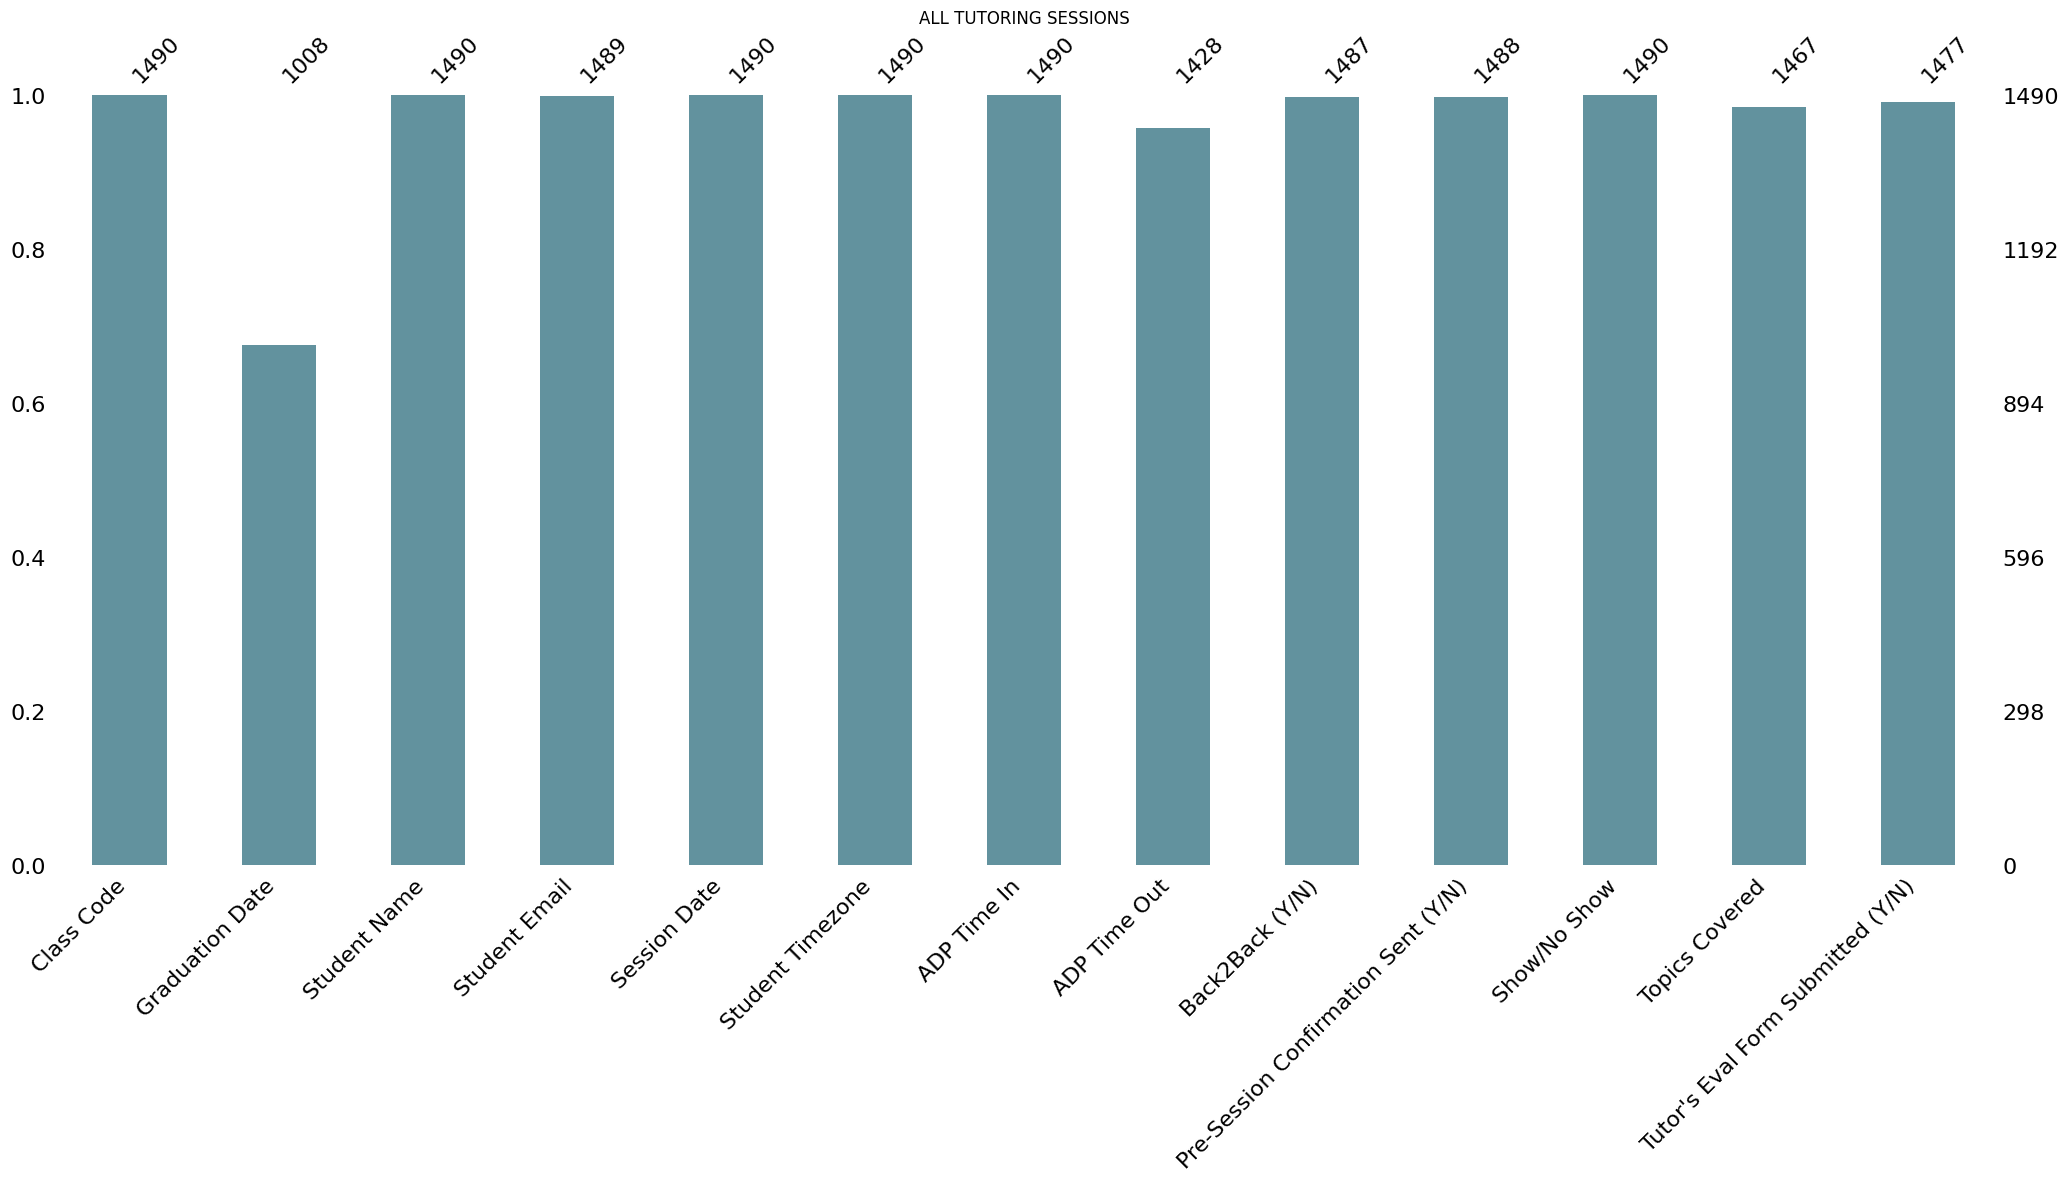

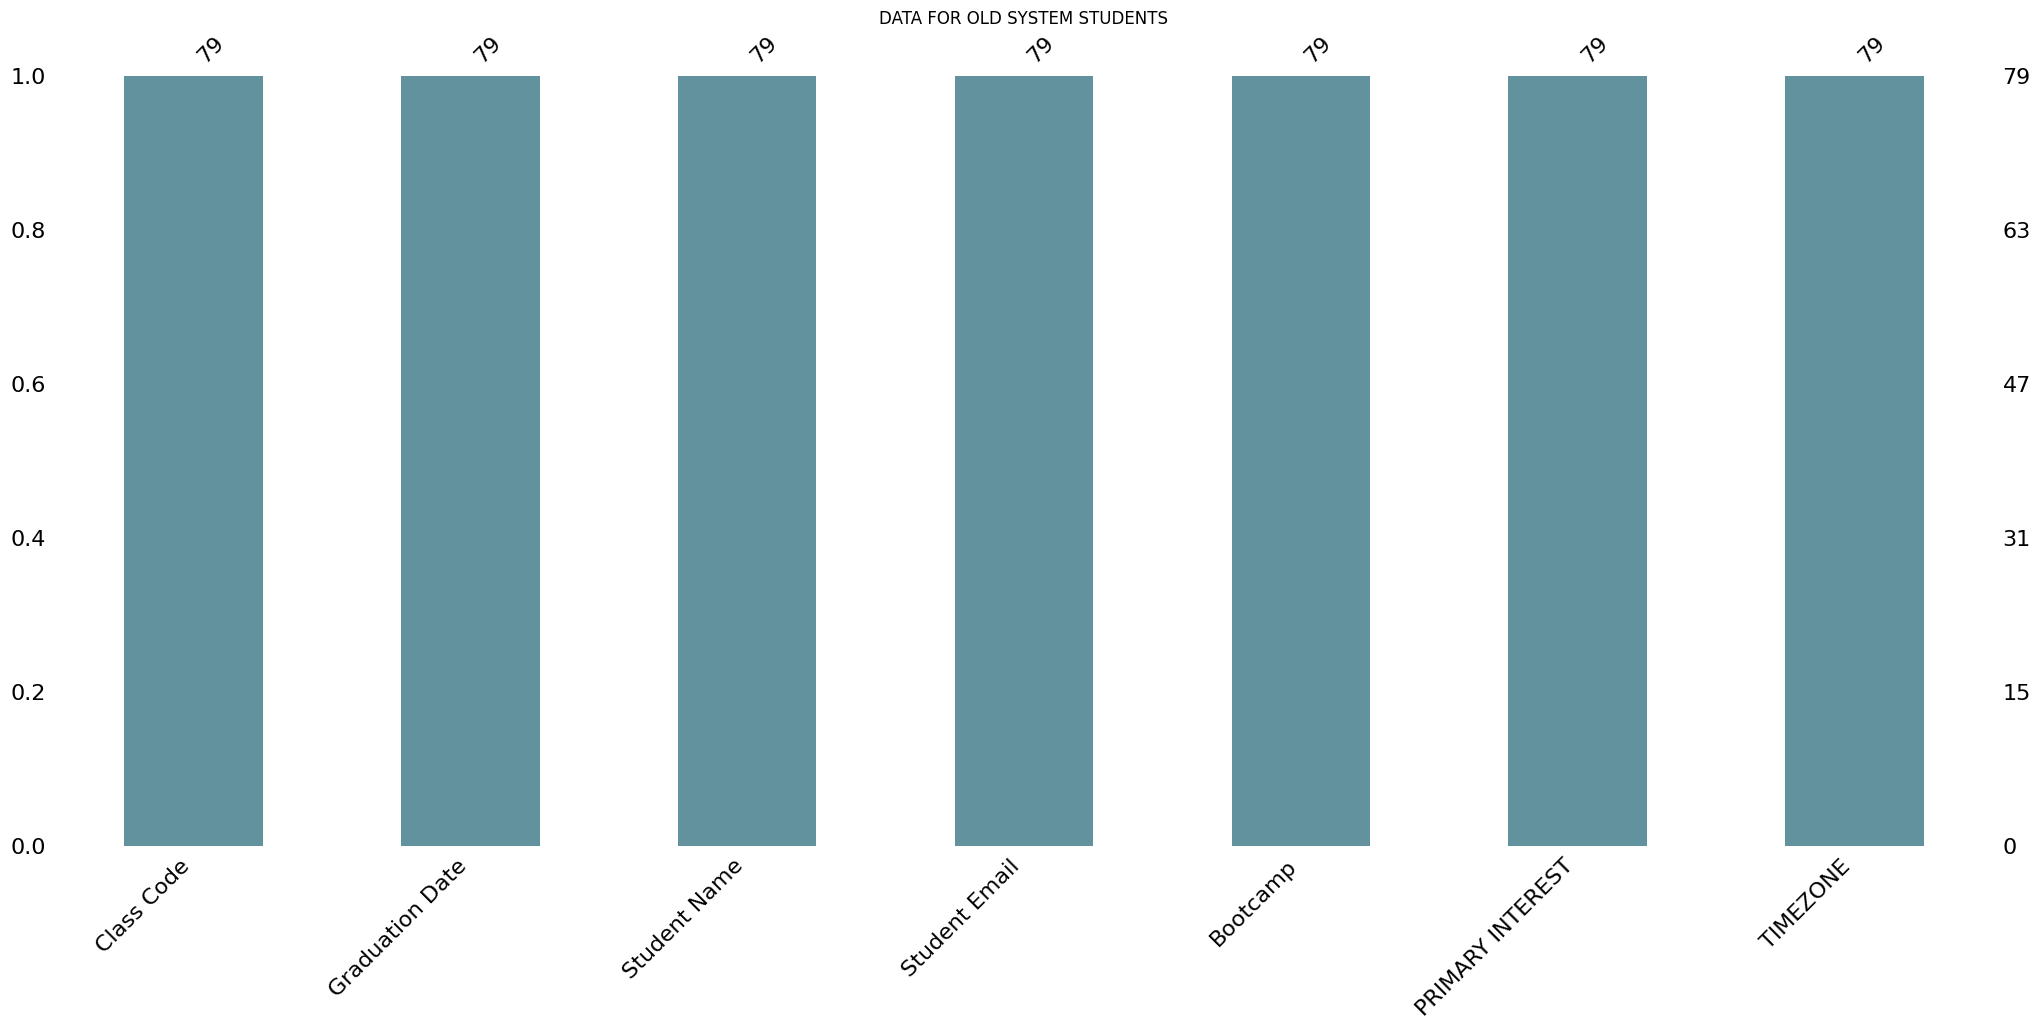

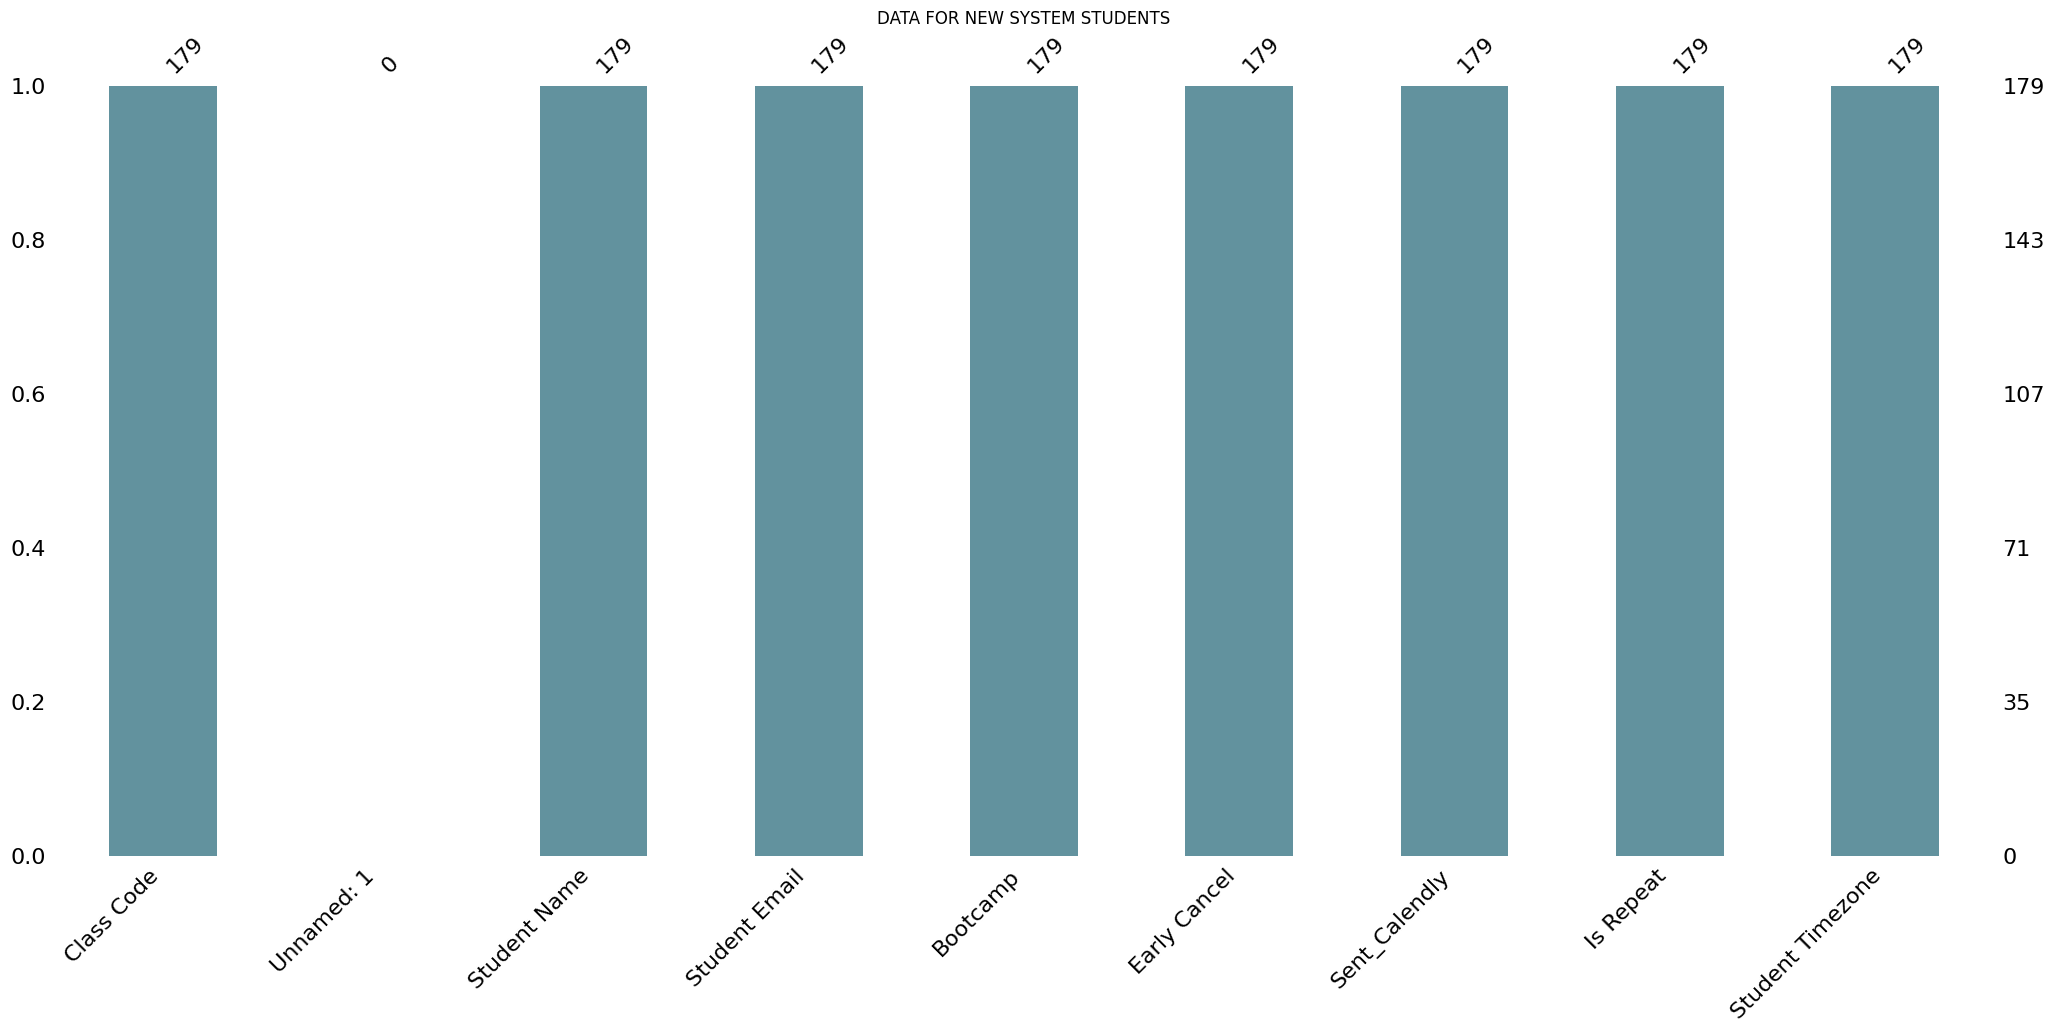

In [2]:
# Using missingno to check which columns have enough values to use for analysis
# (Note: Empty space correlates to a null / NaN value)
check_raw_with_missingno = [
    {"data": raw_past_sessions, "display": "ALL TUTORING SESSIONS"},
    {"data": raw_graduated_students, "display": "DATA FOR OLD SYSTEM STUDENTS"},
    {"data": raw_new_students, "display": "DATA FOR NEW SYSTEM STUDENTS"}
]

for dset in check_raw_with_missingno:
  msno.bar(dset["data"], color="#62929e")
  plt.title(dset["display"])
  plt.show()
  print()

In [3]:
# Here's the columns that are probably useable, given the null amounts and column changes
session_column_list = ["Student Name", "Student Email", "Session Date", "ADP Time In", "ADP Time Out", "Topics Covered"]
student_column_list = ["Student Name", "Student Email", "Bootcamp", "Student Timezone"]

# Also, I prefer doing dot notation when accessing columns, so I'm going to rename these
session_column_rename = ["NAME", "EMAIL", "DATE", "START", "END", "TOPIC"]
student_column_rename = ["NAME", "EMAIL", "BOOTCAMP", "TIMEZONE"]

# In order to do that more easily, we'll have to rename that TIMEZONE column in the old system students df
raw_graduated_students = raw_graduated_students.rename({"TIMEZONE":"Student Timezone"}, axis=1)

In [4]:
def capitalize_columns(df, column_list):
  for col in column_list:
    df[col] = df[col].str.upper()

## Selecting Columns for Past Sessions

In [5]:
# Sometimes students enter their names / emails with mixed case, so I wanted to make everything caps to make things easier to match later
# Due to privacy reasons, we'll be translating name and e-mail into an id, but I need them both here to join sessions and students
# Show/No Show and Topics Covered are capitalized for similar reasons
capitalize_columns(raw_past_sessions, ["Student Name", "Student Email", "Show/No Show", "Topics Covered"])

In [6]:
# Since this is a study of tutoring sessions I've had, I'm filtering out all sessions that students canceled or no showed on me
past_sessions = raw_past_sessions.loc[raw_past_sessions["Show/No Show"] == "SHOW", session_column_list]
past_sessions.columns = session_column_rename
print(f"{past_sessions.shape[0]:,} rows")
print("Past Sessions Columns: ", end='')
past_sessions.columns.to_list()

1,418 rows
Past Sessions Columns: 

['NAME', 'EMAIL', 'DATE', 'START', 'END', 'TOPIC']

## Selecting Columns for Students

In [7]:
print("Graduated Students: ", end='')
raw_graduated_students.columns.to_list()

Graduated Students: 

['Class Code',
 'Graduation Date',
 'Student Name',
 'Student Email',
 'Bootcamp',
 'PRIMARY INTEREST',
 'Student Timezone']

In [8]:
print("New System Students: ", end='')
raw_new_students.columns.to_list()

New System Students: 

['Class Code',
 'Unnamed: 1',
 'Student Name',
 'Student Email',
 'Bootcamp',
 'Early Cancel',
 'Sent_Calendly',
 'Is Repeat',
 'Student Timezone']

In [9]:
# As stated above, students often mix name and email capitalization, so I'm going SQL Case
capitalize_columns(raw_graduated_students, ["Student Name", "Student Email", "Bootcamp", "Student Timezone"])
capitalize_columns(raw_new_students, ["Student Name", "Student Email", "Bootcamp", "Student Timezone"])

In [10]:
# Selecting certain columns from graduated students 
graduated_students = raw_graduated_students.loc[:, student_column_list]
graduated_students.columns = student_column_rename
print(f"{graduated_students.shape[0]:,} rows")
print("Graduated Students: ", end='')
graduated_students.columns.to_list()

79 rows
Graduated Students: 

['NAME', 'EMAIL', 'BOOTCAMP', 'TIMEZONE']

In [11]:
# Selecting certain columns from graduated students 
new_students = raw_new_students.loc[:, student_column_list]
new_students.columns = student_column_rename
print(f"{new_students.shape[0]:,} rows")
print("New System Students: ", end='')
new_students.columns.to_list()

179 rows
New System Students: 

['NAME', 'EMAIL', 'BOOTCAMP', 'TIMEZONE']

In [12]:
# Since both dataframes now have the same columns in the same order, I can combine them
# with a union
students = pd.concat([graduated_students, new_students], axis=0)
# I'm not displaying the name or email here for privacy purposes
students.iloc[:, 2:]

,BOOTCAMP,TIMEZONE
0,FULL_STACK,PACIFIC
1,FULL_STACK,CENTRAL
2,DATA,PACIFIC
3,DATA,AWST
4,DATA,AWST
...,...,...
174,DATA,EASTERN
175,DATA,EASTERN
176,DATA,EASTERN
177,DATA,EASTERN


In [13]:
# We're using Label Encoder to quickly generate an ID for the students
# Occasionally, while working in the old system, I subbed for other tutors
# Label Encoder will file these sessions under "OTHER"
# Since we have the ids, we'll no longer need the NAME and EMAIL columns and can remove them
# for the clean datasets
student_label_enc = LabelEncoder()
vals_to_fit = students["NAME"].to_list()
vals_to_fit.append("OTHER")
student_label_enc.fit(vals_to_fit)
students["ID"] = student_label_enc.transform(students["NAME"])
past_sessions["ID"] = student_label_enc.transform(past_sessions["NAME"].map(lambda n: "OTHER" if n not in student_label_enc.classes_ else n))
students = students.drop(columns=["NAME","EMAIL"])
past_sessions = past_sessions.drop(columns=["NAME", "EMAIL"])

In [14]:
# Sometimes the web students are entered under WEB or FRONT END, so I'm streamlining the
# names to DATA and FULL_STACK
students["BOOTCAMP"] = students.BOOTCAMP.map(lambda b: "DATA" if "DATA" in b else "FULL_STACK")
students.BOOTCAMP.value_counts()

DATA          179
FULL_STACK     79
Name: BOOTCAMP, dtype: int64

In [15]:
# Also streamlining some of the timezone entries
students.loc[students["TIMEZONE"] == "PERTH", "TIMEZONE"] = "AWST"
students.loc[students["TIMEZONE"] == "UK_IRELAND", "TIMEZONE"] = "IRELAND"
students.TIMEZONE.value_counts()

EASTERN     108
PACIFIC      56
CENTRAL      47
MOUNTAIN     19
AWST         11
IRELAND       9
ARIZONA       4
AEST          2
AUCKLAND      1
ATLANTIC      1
Name: TIMEZONE, dtype: int64

## Fixing Session Times

In [16]:
# There's quite a few end recordings that are off in the dataset (for example, using AM/PM)
# So we're cycling through them here and creating a clean dataset
invalid_entry_translator = {
    "100":"12:00",
    "127":"17:21",
    "168":"13:00",
    "210":"13:00",
    "215":"14:00",
    "227":"11:19",
    "251":"16:11",
    "273":"13:09",
    "361":"13:38",
    "463":"16:01",
    "490":"20:03",
    "506":"15:00",
    "516":"13:01",
    "622":"18:10",
    "778":"20:30",
    "823":"20:02",
    "864":"15:01",
    "914":"16:10",
    "931":"16:20",
    "1016":"18:20",
    "1035":"17:50",
    "1070":"16:30",
    "1086":"13:11",
    "1102":"16:20",
    "1141":"16:20",
    "1180":"10:30",
    "1194":"10:00",
    "1209":"13:00",
    "1274":"14:30",
    "1314":"18:15",
    "1350":"15:00",
    "1351":"16:00"
}

for str_idx, new_end in invalid_entry_translator.items():
  idx = int(str_idx)
  past_sessions.loc[idx, "END"] = new_end

past_sessions.loc[idx]

DATE      1/10/2023
START         14:00
END           16:00
TOPIC    SQLALCHEMY
ID               70
Name: 1351, dtype: object

In [17]:
# Just wanted to make sure there's a : between the hour and minutes
for col in ["START", "END"]:
  past_sessions[col] = past_sessions[col].str.replace(';', ':')

In [18]:
# This function will extract a datetime version of the start or end time
# depending on which the user specifies in start_or_end
def extract_datetime(row, start_or_end="start"):
  date = [int(val) for val in row.DATE.split('/')]

  if date[2] == 1202:
    date [2] = 2012
  elif date[2] == 2921:
    date[2] = 2021

  try: 
    start_hours, start_minutes = [int(val) for val in row.START.split(":")]
    end_hours, end_minutes = [int(val) for val in row.END.split(":")]
  except:
    start_hours, start_minutes = [int(val) for val in row.START.split(":")]
    end_hours = start_hours + 1
    end_minutes = start_minutes

  if start_hours > end_hours:
    print(row.name, end=", ")

  if start_hours >= 24:
    start_hours = 0
  elif end_hours >= 24:
    end_hours = 0

  if start_or_end == "start":
    return datetime(date[2], date[0], date[1], start_hours, start_minutes)
  else:
    try:
      return datetime(date[2], date[0], date[1], end_hours, end_minutes)
    except Exception as e:
      print(row.name, e)
      return 

# Creating a datetime version of Start and End times so we can calculate the duration of the session
past_sessions["START_FULL"] = past_sessions.apply(lambda row: extract_datetime(row, "start"), axis=1)
past_sessions["END_FULL"] = past_sessions.apply(lambda row: extract_datetime(row, "end"), axis=1)
past_sessions["DURATION"] = (past_sessions["END_FULL"] - past_sessions["START_FULL"]).dt.total_seconds() // 60
past_sessions

,DATE,START,END,TOPIC,ID,START_FULL,END_FULL,DURATION
0,12/09/2020,11:59,12:56,EXCEL HOMEWORK,181,2020-12-09 11:59:00,2020-12-09 12:56:00,57.0
1,12/10/2020,05:31,06:23,TAILWIND CSS; MONGOOSE,181,2020-12-10 05:31:00,2020-12-10 06:23:00,52.0
2,12/11/2020,14:00,15:00,EXCEL HOMEWORK,181,2020-12-11 14:00:00,2020-12-11 15:00:00,60.0
3,12/14/2020,15:00,16:40,VANILLA JAVASCRIPT DOM MANIPULATION,27,2020-12-14 15:00:00,2020-12-14 16:40:00,100.0
5,12/18/2020,07:59,08:55,GIT TROUBLESHOOTING,60,2020-12-18 07:59:00,2020-12-18 08:55:00,56.0
...,...,...,...,...,...,...,...,...
1484,03/30/2023,14:00,15:00,APIS,161,2023-03-30 14:00:00,2023-03-30 15:00:00,60.0
1485,03/30/2023,15:00,16:00,GIT,216,2023-03-30 15:00:00,2023-03-30 16:00:00,60.0
1486,03/31/2023,10:00,11:00,DOM_MANIPULATION,54,2023-03-31 10:00:00,2023-03-31 11:00:00,60.0
1487,03/31/2023,11:00,12:00,PYTHON,197,2023-03-31 11:00:00,2023-03-31 12:00:00,60.0


In [19]:
# Double-checking to ensure that the session duration column looks accurate
past_sessions.DURATION.describe()

count    1418.000000
mean       63.359661
std        17.055776
min        10.000000
25%        60.000000
50%        60.000000
75%        61.000000
max       219.000000
Name: DURATION, dtype: float64

In [20]:
# Ensuring that there's no sessions here that 0 minutes or less (as this would imply an error in the start / end hour)
past_sessions.loc[past_sessions.DURATION <= 0]

,DATE,START,END,TOPIC,ID,START_FULL,END_FULL,DURATION


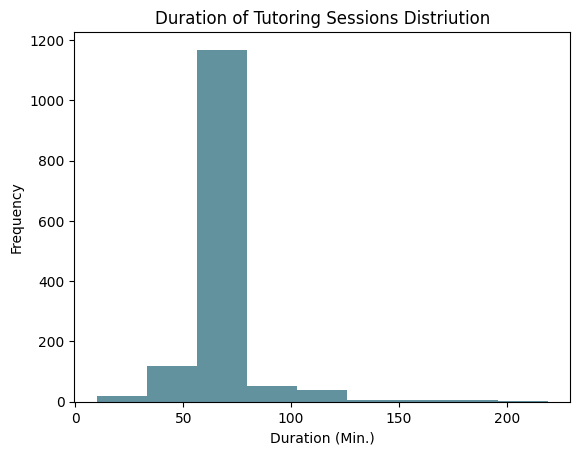

In [21]:
# Also checking the distribution of sessions to make sure that data is gathered around
# the 60 minute point since a standard session is 50 minutes
past_sessions.DURATION.plot.hist(bins=9, color="#62929e")
plt.title("Duration of Tutoring Sessions Distriution")
plt.xlabel("Duration (Min.)")
plt.show()

## Cleaning / Binning Session Topics

Since the session topics are all over the place and I want to examine how many sessions I've had on each topic, I need to go through and bin the topics by content.

In [22]:
# Like you can see, when I first started, I entered really detailed topics,
# so I just want to go through and bin them to make the topics more concise
past_sessions.TOPIC.value_counts()

SQL                                    99
ML_SUPERVISED                          74
JAVASCRIPT                             70
GIT                                    64
PANDAS                                 60
                                       ..
FLASK, BACKENDS, HEROKU, DEPLOYMENT     1
FINAL PROJECT (OAUTH)                   1
UNIT ASSESSMENT FOR VISUALIZATION       1
FLASK, AWS RDS                          1
SQLALCEHMY                              1
Name: TOPIC, Length: 217, dtype: int64

In [23]:
# We're going to use parse topic to bin topics
for disp_topic, poss_topic_list in topics_parse.items():
 for poss_topic in poss_topic_list:
   past_sessions.loc[past_sessions["TOPIC"].str.contains(poss_topic, na=False, case=False), "TOPIC"] = disp_topic

past_sessions.loc[past_sessions["TOPIC"] == "R", "TOPIC"] = "STATISTICS"

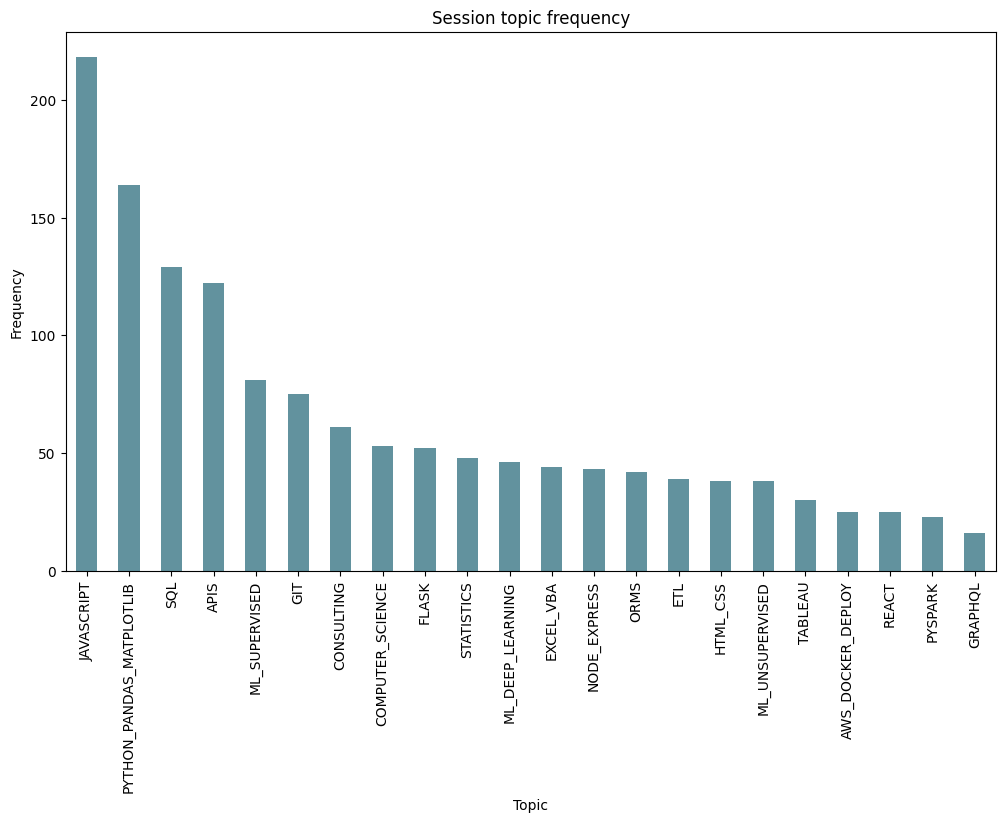

In [24]:
# JavaScript is by-and-large the most frequent tutoring topic--which makes sense as
# both web and data students learn JavaScript at some point (Plus, web students use
# JavaScript throughout their bootcamp)
past_sessions.TOPIC.value_counts().plot.bar(figsize=(12,7), color="#62929e")
plt.title("Session topic frequency")
plt.ylabel("Frequency")
plt.xlabel("Topic")
plt.show()

## Preparing the Dataset for static dashboard use

In [25]:
final_sessions = past_sessions[["DATE", "START_FULL", "END_FULL", "DURATION", "ID", "TOPIC"]]
final_sessions.columns = ["DATE", "START", "END", "DURATION", "ID", "TOPIC"]
final_sessions

,DATE,START,END,DURATION,ID,TOPIC
0,12/09/2020,2020-12-09 11:59:00,2020-12-09 12:56:00,57.0,181,EXCEL_VBA
1,12/10/2020,2020-12-10 05:31:00,2020-12-10 06:23:00,52.0,181,SQL
2,12/11/2020,2020-12-11 14:00:00,2020-12-11 15:00:00,60.0,181,EXCEL_VBA
3,12/14/2020,2020-12-14 15:00:00,2020-12-14 16:40:00,100.0,27,JAVASCRIPT
5,12/18/2020,2020-12-18 07:59:00,2020-12-18 08:55:00,56.0,60,SQL
...,...,...,...,...,...,...
1484,03/30/2023,2023-03-30 14:00:00,2023-03-30 15:00:00,60.0,161,APIS
1485,03/30/2023,2023-03-30 15:00:00,2023-03-30 16:00:00,60.0,216,GIT
1486,03/31/2023,2023-03-31 10:00:00,2023-03-31 11:00:00,60.0,54,JAVASCRIPT
1487,03/31/2023,2023-03-31 11:00:00,2023-03-31 12:00:00,60.0,197,PYTHON_PANDAS_MATPLOTLIB


In [26]:
final_students = students[["ID", "BOOTCAMP", "TIMEZONE"]]
final_students

,ID,BOOTCAMP,TIMEZONE
0,27,FULL_STACK,PACIFIC
1,38,FULL_STACK,CENTRAL
2,96,DATA,PACIFIC
3,237,DATA,AWST
4,80,DATA,AWST
...,...,...,...
174,45,DATA,EASTERN
175,73,DATA,EASTERN
176,106,DATA,EASTERN
177,66,DATA,EASTERN


In [27]:
final_sessions.to_csv("./clean/sessions.csv", index=False)
final_students.to_csv("./clean/students.csv", index=False)